In [54]:
#Dependencies
import pandas as pd
import numpy as np
import os
import time
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
pymysql.install_as_MySQLdb() 
import math
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [90]:
# path config
# First we'll import the os module
# This will allow us to create file paths across operating systems
#os.getcwd()
df_books = pd.read_csv(os.path.join("Resources", "clean_book_data.csv"), encoding="ISO-8859-1",dtype={'ISBN': 'str', 'Title': 'str','User-ID': 'int32', 'Book-Rating': 'float32'}, usecols=["ISBN","Title"])
df_books.head()

# data_path = os.path.join(os.environ['DATA_PATH'], 'MovieLens')
# movies_filename = 'movies.csv'
# ratings_filename = 'ratings.csv'

,ISBN,Title
0,399135782,The Kitchen God's Wife
1,399135782,The Kitchen God's Wife
2,399135782,The Kitchen God's Wife
3,399135782,The Kitchen God's Wife
4,399135782,The Kitchen God's Wife


In [201]:
df_books.shape

(223996, 3)

In [199]:
df_ratings = pd.read_csv(os.path.join("Resources", "clean_book_data.csv"), encoding="ISO-8859-1",dtype={'ISBN': 'str', 'Title': 'str','User-ID': 'int32', 'Book-Rating': 'float32'}, usecols=['User-ID', 'ISBN', 'Book-Rating'])
df_ratings.head()

,ISBN,User-ID,Book-Rating
0,399135782,8,0.0
1,399135782,11676,9.0
2,399135782,29526,9.0
3,399135782,36836,0.0
4,399135782,46398,9.0


In [200]:
df_ratings.shape

(223996, 3)

In [80]:
# df['Book-Rating'] = df['Book-Rating'].astype(float)
# df

In [57]:
# #You must specify the axis argument. default is axis = 0 which is rows columns is axis = 1
# df = df.drop("ISBN", axis=1)
# df.head()

In [69]:
# for index, row in df['ISBN'].iteritems():
#     if pd.isnull(row):
#         print('index:', index, 'isnull')

In [70]:
# df['ISBN'] = pd.to_numeric(df['ISBN'], errors='coerce')
# df['ISBN'] = df['ISBN'].astype(int)
# df

In [82]:
# df_books = pd.read_csv(
#     os.path.join(data_path, books_filename),
#     usecols=['ISBN', 'Title'],
#     dtype={'ISBN': 'int32', 'Title': 'str'})

# df_ratings = pd.read_csv(
#     os.path.join(data_path, ratings_filename),
#     usecols=['User-ID', 'ISBN', 'Book-Rating'],
#     dtype={'User-ID': 'int32', 'ISBN': 'int32', 'Book-Rating': 'float32'})

In [92]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223996 entries, 0 to 223995
Data columns (total 3 columns):
ISBN           223996 non-null object
User-ID        223996 non-null int32
Book-Rating    223996 non-null float32
dtypes: float32(1), int32(1), object(1)
memory usage: 3.4+ MB


In [93]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223996 entries, 0 to 223995
Data columns (total 3 columns):
ISBN           223996 non-null object
User-ID        223996 non-null int32
Book-Rating    223996 non-null float32
dtypes: float32(1), int32(1), object(1)
memory usage: 3.4+ MB


In [198]:
num_users = len(df_ratings['User-ID'].unique())
num_items = len(df_ratings['ISBN'].unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 29636 unique users and 9714 unique books in this data set


In [98]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('Book-Rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
Book-Rating,
0.0,131385
1.0,235
2.0,433
3.0,913
4.0,1479
5.0,8108
6.0,6148
7.0,14909
8.0,22943


In [100]:
# # there are a lot more counts in rating of zero
# total_cnt = num_users * num_items
# rating_zero_cnt = total_cnt - df_ratings.shape[0]
# # append counts of zero rating to df_ratings_cnt
# df_ratings_cnt = df_ratings_cnt_tmp.append(
#     pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
#     verify_integrity=True,
# ).sort_index()
# df_ratings_cnt

In [103]:
# add log count
df_ratings_cnt_tmp['log_count'] = np.log(df_ratings_cnt_tmp['count'])
df_ratings_cnt_tmp

,count,log_count
Book-Rating,,
0.0,131385,11.785887
1.0,235,5.459586
2.0,433,6.070738
3.0,913,6.816736
4.0,1479,7.299121
5.0,8108,9.000607
6.0,6148,8.723882
7.0,14909,9.609720
8.0,22943,10.040768


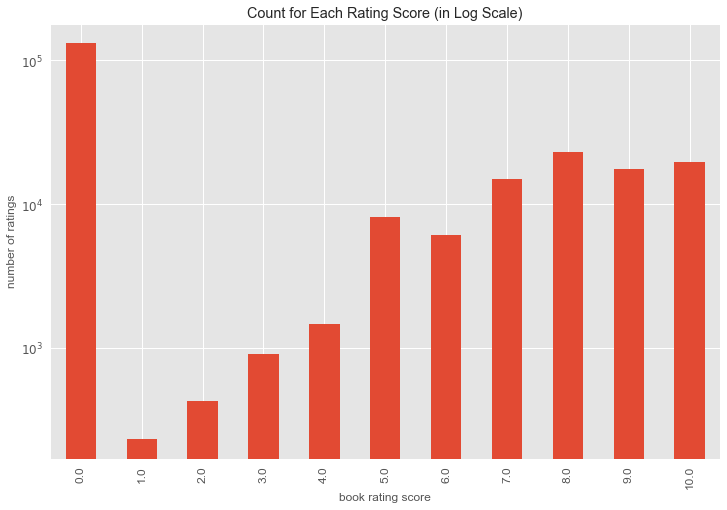

In [112]:
ax = df_ratings_cnt_tmp['count'].sort_index().rename(columns={'index': 'Book-Rating score'}).plot(
    x='Book-Rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")

In [113]:
df_ratings.head()

,ISBN,User-ID,Book-Rating
0,399135782,8,0.0
1,399135782,11676,9.0
2,399135782,29526,9.0
3,399135782,36836,0.0
4,399135782,46398,9.0


In [191]:
# get rating frequency
df_books_cnt = pd.DataFrame(df_ratings.groupby('ISBN').size(), columns=['count'])
df_books_cnt.head()

,count
ISBN,
000160418X,2
000673765X,1
002711080X,1
003061368X,1
006015425X,1


In [202]:
df_books_cnt.shape

(9714, 1)

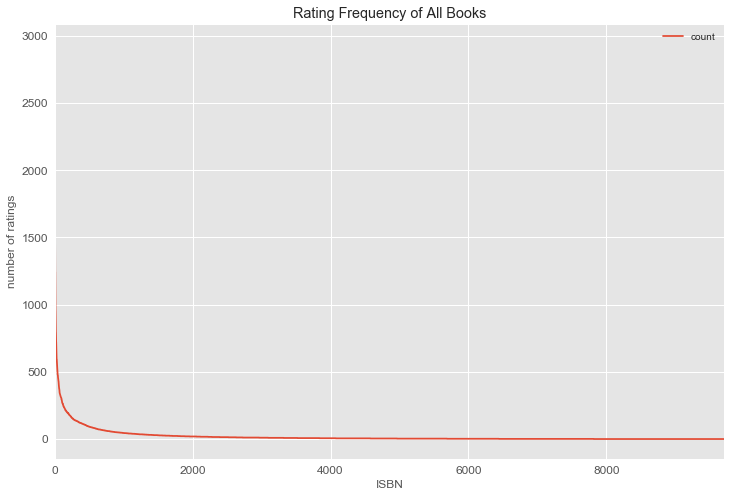

In [116]:
# plot rating frequency of all books
ax = df_books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books',
        fontsize=12
    )
ax.set_xlabel("ISBN")
ax.set_ylabel("number of ratings")

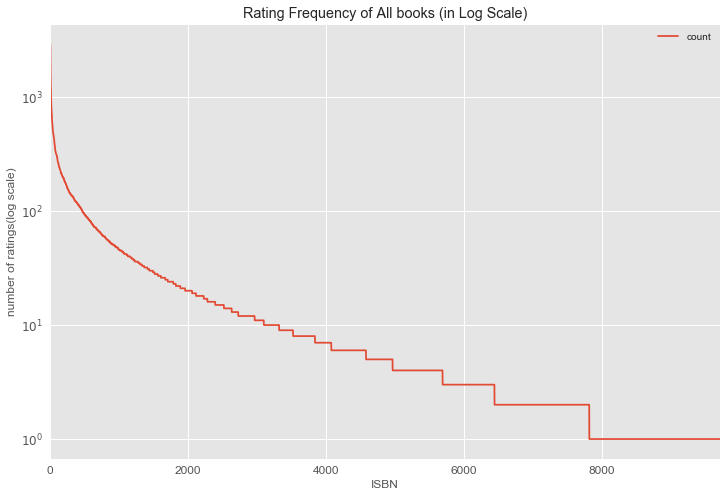

In [119]:
# plot rating frequency of all books in log scale
ax = df_books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All books (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("ISBN")
ax.set_ylabel("number of ratings(log scale)")

In [120]:
df_books_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2941.0
0.95      96.0
0.90      48.0
0.85      30.0
0.80      21.0
0.75      15.0
0.70      12.0
0.65       9.0
Name: count, dtype: float64

In [121]:
# filter data
popularity_thres = 50
popular_books = list(set(df_books_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_books = df_ratings[df_ratings.ISBN.isin(popular_books)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular books: ', df_ratings_drop_books.shape)

shape of original ratings data:  (223996, 3)
shape of ratings data after dropping unpopular books:  (151758, 3)


In [203]:
df_ratings_drop_books.head()

,ISBN,User-ID,Book-Rating
0,399135782,8,0.0
1,399135782,11676,9.0
2,399135782,29526,9.0
3,399135782,36836,0.0
4,399135782,46398,9.0


In [209]:
df_ratings_drop_books2 = df_ratings_drop_books.copy()
df_ratings_drop_books2

,ISBN,User-ID,Book-Rating
0,399135782,8,0.0
1,399135782,11676,9.0
2,399135782,29526,9.0
3,399135782,36836,0.0
4,399135782,46398,9.0
5,399135782,49300,0.0
6,399135782,49635,9.0
7,399135782,67958,10.0
8,399135782,113270,0.0
9,399135782,113519,0.0


In [210]:
df_ratings_drop_books3 = df_ratings_drop_books2.drop_duplicates(subset=["ISBN"]) 

In [211]:
df_ratings_drop_books3.shape

(937, 3)

In [212]:
df_ratings_drop_books3.head()

,ISBN,User-ID,Book-Rating
0,399135782,8,0.0
60,080410753X,277427,0.0
558,804106304,276925,0.0
1063,399146431,278314,7.0
1177,804114986,277171,0.0


In [122]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_books.groupby('User-ID').size(), columns=['count'])
df_users_cnt.head()

,count
User-ID,
8,2
9,1
16,1
17,3
26,8


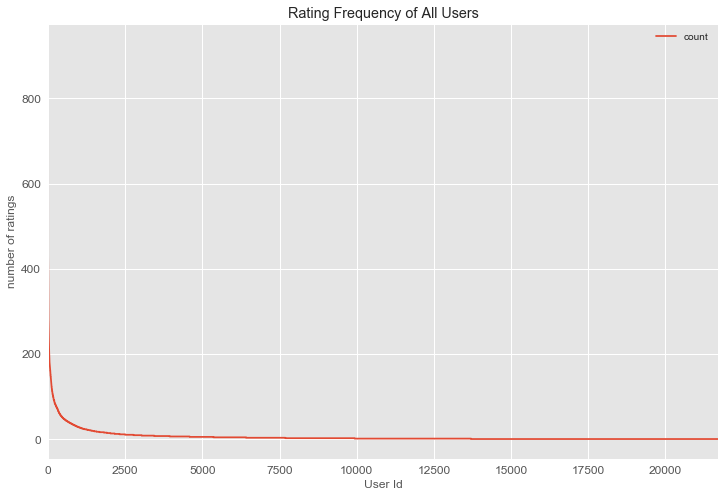

In [123]:
# plot rating frequency of all books
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings")

In [124]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    928.0
0.95     26.0
0.90     13.0
0.85      9.0
0.80      7.0
0.75      5.0
0.70      4.0
0.65      4.0
0.60      3.0
0.55      3.0
Name: count, dtype: float64

In [130]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_books[df_ratings_drop_books['User-ID'].isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular books and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (223996, 3)
shape of ratings data after dropping both unpopular books and inactive users:  (50883, 3)


In [196]:
# pivot and create book-user matrix
book_user_mat = df_ratings_drop_users.pivot(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)
# create mapper from movie title to index
book_to_idx = {
    book: i for i, book in 
    enumerate(list(df_books_new.set_index('ISBN').loc[book_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
book_user_mat_sparse = csr_matrix(book_user_mat.values)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)

In [ ]:
def fuzzy_matching(mapper, fav_book, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the book in data

    fav_book: str, name of user input book
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    """
    return top n similar book recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_book: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar book recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input book:', fav_book)
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Wuthering Heights'

make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=book_to_idx,
    n_recommendations=10)

In [ ]:
# calculate total number of entries in the book-user matrix
num_entries = book_user_mat.shape[0] * book_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (book_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

In [ ]:
import pickle
pickle.dump(clf, open('models/final_prediction.pickle', 'wb'))